# Normalizing Flows
## A short stroll from discrete to continuous time
<br><br>
## Aalto University, EEA
Adrien Corenflos, 2.11.2020

# Outline

1. Generative models

2. Problem formulation

3. Discrete time normalizing flows

4. Continuous time normalizing flows

# Generative models

## Definition

Statistical models are usually divided in two classes: discriminative and generative <cite>[1, Ch.2]</cite>.

- discriminative:<br>
    Discriminative models are a class of statistical models encode the conditional distribution of the observation given the input
    $$
    \begin{equation}
        \mathbb{P}(Y \mid X)
    \end{equation}
    $$
    


- generative:<br>
    Generative models on the other end encode the joint distribution of the input and the observation
    $$
    \begin{equation}
        \mathbb{P}(X, Y)
    \end{equation}
    $$

## Some examples:

| Discriminative | Generative |
| --- | --- |
| Logistic regression | Naive Bayes classifier |
| Support vector machines | Gaussian Processes |
| Decision trees | Bayesian Networks | 
| Neural Networks | ? |

# Problem formulation

## The data generation problem

We will consider the two following problems:


1. Given a series of observations $Y_n$'s, how do we calibrate a probabilistic model that is able to generate "similar" data?
    For example, how can we generate handwritten numbers:

In [8]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

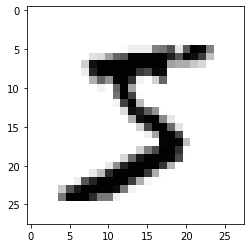

In [9]:
import matplotlib.pyplot as plt
_ = plt.imshow(1 - X[0].reshape(28, 28), cmap="gray")

2. Given a complicated likelihood function how do we sample from it? For example:

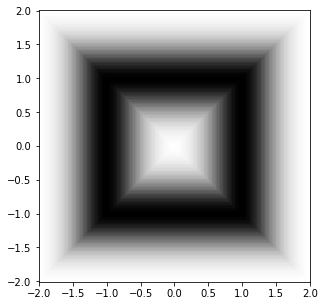

In [10]:
import numpy as np

def square(x, y):
    abs_x = np.abs(x)
    abs_y = np.abs(y)
    return 0.25 * np.exp(-4*(np.maximum(abs_x, abs_y) - 1) ** 2) / np.sqrt(np.pi)

def plot_square():
    linspace = np.linspace(-2., 2., 200)
    mesh_x, mesh_y = np.meshgrid(linspace, linspace)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_aspect("equal")
    _ = ax.pcolormesh(mesh_x, mesh_y, 1. - square(mesh_x, mesh_y), cmap="gray", shading='auto')

plot_square()

## Non exhaustive solutions

1. Data registration:  
    a. Variational auto-encoders  
    b. Generative adversarial networks  
    c. Normalizing flows

2. Distribution sampling:  
    a. MCMC  
    b. Normalizing flows

1.a. VAE  
    Learn a latent representation of the distribution 
    ![image-4.png](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png)

Image from Wikimedia. To go further see [2].

1.b. GAN  
    Learn to fool a expert networks, or more recently learn to minimize Wasserstein distance between true and generated. 
    $$\underset{\theta}{\min} \mathcal{W}\bigg(G_\theta, [Y_n]_{n=1}^N\bigg)$$
    
To go further see [3].

2.a. MCMC  
    Acceptance-rejection method for exact sampling. 

In [11]:
def mh(f, n=1000, seed=0):
    rng = np.random.RandomState(seed)
    arr = np.empty((n, 2))
    x, y = rng.uniform(-1, 1, 2)
    p = f(x, y)
    for i in range(n):
        eps_x, eps_y = rng.uniform(-1, 1, 2)
        xi, yi = x + eps_x, y + eps_y
        pi = f(xi, yi)
        if rng.rand() <= pi / p:
            x, y = xi, yi
            p = pi
        arr[i] = x, y
    return arr

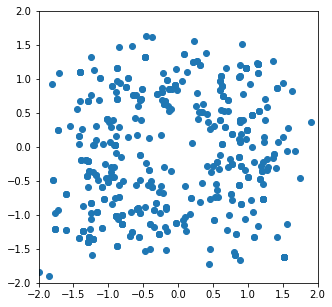

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-2, 2), ax.set_ylim(-2, 2)
_ = ax.scatter(*mh(square, 500).T)

# Discrete time normalizing flows

## Principle
- Flow: stands for composition
- Normalizing: stands for the fact that each transformation is normalizing: keeps total probability mass constant

$$
\begin{align}
    X_0 &\sim U([0, 1]^d) \quad \text{or} \quad \mathcal{N}(0, I_d) \\
    X_i &= f_i(X_{i-1}, \theta_i)
\end{align}
$$

Normalizing means that $f_i$ needs to be invertible.

## Change of variable

Let $Z = f(X)$,
$$p_Z(z) = p_X(f^{-1}(z)) \cdot \mathrm{d}V(f^{-1}(z))$$
where $dV$ is local the change of volume incurred by the change of variable.

Lebesgue theory tells us that 
$$\mathrm{d}V = \left| \mathrm{det}J_f^{-1}\right| = \left| \mathrm{det}J_f\right|^{-1}$$

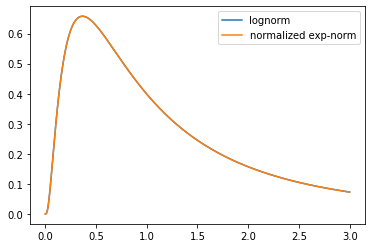

In [13]:
import scipy.stats as st

def f(x): return np.exp(x)
def dV(z): return 1/z

linspace = np.linspace(1e-3, 3., 10000)
_ = plt.plot(linspace, st.lognorm.pdf(s=1., x=linspace), label="lognorm")
_ = plt.plot(linspace, st.norm.pdf(x=np.log(linspace)) * dV(linspace), label="normalized exp-norm")
_ = plt.legend()

## Flows  and chain rule

So now the composed model reads:
$$
\begin{align}
    Z = X_n = f_n(f_{n-1}(\dots, \theta_{n-1}), \theta_n))
\end{align}
$$

so that $p_Z(z) = p_X(x) \prod_{i=1}^n \left|\mathrm{det}J_{f_i}^{-1}\right|$, or said otherwise:
$$
\ln p_Z(z) = \ln p_X(x) - \sum_{i=1}^n \ln \left|\mathrm{det}J_{f_i}\right|
$$
for which we want to compute the gradient with respect to $\theta = [\theta_n, \dots, \theta_1]$

So how do we compute $\frac{\partial}{\partial \theta_i} \ln \left|\mathrm{det}J_{f_i}\right|$ ? 

$$ \mathrm{d}(\ln\left| \mathrm{det}(M)\right|) = M^{-\top}\mathrm{d}M$$
So that we need to invert all the $J_{f_i}$: ($O(N^3)$)!!!

This restricts the practical form of the $f_i$'s quite a bit to functions for which the log-determinant of the Jacobian has an easy to compute form: triangular Jacobian, or...

## Planar flows [4]


$$
\begin{align}
    f(\mathbf{x}, \mathbf{a}, b, \mathbf{w}) = \mathbf{x} + \sigma(\mathbf{w}^\top \cdot \mathbf{x} + b) \mathbf{a}
\end{align}
$$

$$
\begin{align}
    J_f = I + \sigma'(\mathbf{w}^\top \cdot \mathbf{x} + b) \mathbf{a} \cdot \mathbf{w}^\top
\end{align}
$$

for which, using the [Matrix determinant lemma](https://en.wikipedia.org/wiki/Matrix_determinant_lemma), we get

$$
\begin{align}
    \mathrm{det}(J_f)= 1 + \sigma'(\mathbf{w}^\top \cdot \mathbf{x} + b) \cdot \mathbf{a}^\top \cdot \mathbf{w}
\end{align}
$$

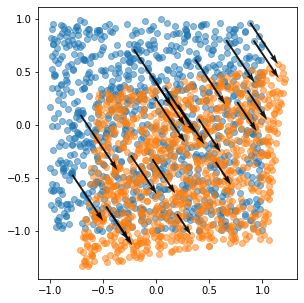

In [14]:
def sigmoid(y): return 1 / (1 + np.exp(-y)) 

def planar_flow_sigmoid(x, a, b, w): return x + sigmoid(x @ w + b).reshape(-1, 1) * a.reshape(1, -1)

uniform = np.random.uniform(-1, 1, (1000, 2))
a = np.array([0.5, -0.75])
b = 0.
w = np.array([-1, 1])
transformed_uniform = planar_flow_sigmoid(uniform, a, b, w)

fig, ax = plt.subplots(figsize=(5, 5),)
ax.set_aspect(aspect="equal")
_ = ax.scatter(*uniform.T, alpha=0.5)
_ = ax.scatter(*transformed_uniform.T, alpha=0.5)
_ = ax.quiver(*uniform[:20].T, *(transformed_uniform[:20].T - uniform[:20].T), 
              units='xy', angles="xy", scale=1, alpha=0.9)

##  Masked Autoregressive Flows [5]

$$
\begin{align}
    f(\mathbf{x}, \mathbf{a}, b, \mathbf{w}) = \mathbf{x} + \sigma(\mathbf{w}^\top \cdot \mathbf{x} + b) \mathbf{a}
\end{align}
$$

$$
\begin{align}
    J_f = I + \sigma'(\mathbf{w}^\top \cdot \mathbf{x} + b) \mathbf{a} \cdot \mathbf{w}^\top
\end{align}
$$

for which, using the [Matrix determinant lemma](https://en.wikipedia.org/wiki/Matrix_determinant_lemma), we get

$$
\begin{align}
    \mathrm{det}(J_f)= 1 + \sigma'(\mathbf{w}^\top \cdot \mathbf{x} + b) \cdot \mathbf{a}^\top \cdot \mathbf{w}
\end{align}
$$

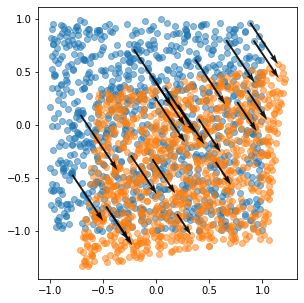

In [14]:
def sigmoid(y): return 1 / (1 + np.exp(-y)) 

def planar_flow_sigmoid(x, a, b, w): return x + sigmoid(x @ w + b).reshape(-1, 1) * a.reshape(1, -1)

uniform = np.random.uniform(-1, 1, (1000, 2))
a = np.array([0.5, -0.75])
b = 0.
w = np.array([-1, 1])
transformed_uniform = planar_flow_sigmoid(uniform, a, b, w)

fig, ax = plt.subplots(figsize=(5, 5),)
ax.set_aspect(aspect="equal")
_ = ax.scatter(*uniform.T, alpha=0.5)
_ = ax.scatter(*transformed_uniform.T, alpha=0.5)
_ = ax.quiver(*uniform[:20].T, *(transformed_uniform[:20].T - uniform[:20].T), 
              units='xy', angles="xy", scale=1, alpha=0.9)

## In practice:

In this small example we will be learning how to generate the number $5$ using the MNIST dataset:

In [15]:
five_data_mask = y == '5'
five_data = X[five_data_mask]

five_data = five_data.reshape(-1, 28, 28)
print(five_data.shape)

(6313, 28, 28)


## Model code

In [17]:
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors

class MAF(tfb.Bijector):
    

In [ ]:
def loss(a_list, b_list, w_list):
    

# References

[1]: Jebara, Tony. Machine Learning: Discriminative and Generative, Springer US, 2004.  
[2]: Doersch, Carl. Tutorial on variational autoencoders, arXiv:1606.05908.  
[3]: Genevay, Aude and al. Learning Generative Models with Sinkhorn Divergences, AISTATS, 2018.  
[4]: Rezende, Danilo and Mohamed, ShakirVariational Inference with Normalizing Flows, ICML, 2015.  
[5]: Papamakarios, George and al. Masked Autoregressive Flow for Density Estimation, NEURIPS, 2017.

In [ ]:
Papamakarios